In [53]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing

from mlsurfzone.lotus_dataset import LotusDataset
from mlsurfzone.validate import plot_cm

plt.rcParams.update({'figure.max_open_warning': 0})

## Very Basic Analytical Conditions Ratings: Wind Direction/Strength Only

In [54]:
# Specify dataset created by `match_windstation_data.py`
df = pd.read_csv('ws_stingy_full.csv')

In [55]:
df.columns

Index(['Unnamed: 0', 'SpotID', 'UnixTime', 'LotusSigH', 'LotusSigH_part1',
       'LotusTp_part1', 'LotusPdir_part1', 'LotusSpred_part1',
       'LotusBreaking_part1', 'LotusPdir_norm_part1', 'LotusSigH_part2',
       'LotusTp_part2', 'LotusPdir_part2', 'LotusSpred_part2',
       'LotusBreaking_part2', 'LotusPdir_norm_part2', 'LotusSigH_part3',
       'LotusTp_part3', 'LotusPdir_part3', 'LotusSpred_part3',
       'LotusBreaking_part3', 'LotusPdir_norm_part3', 'LotusSigH_part4',
       'LotusTp_part4', 'LotusPdir_part4', 'LotusSpred_part4',
       'LotusBreaking_part4', 'LotusPdir_norm_part4', 'GFS_wind_speed',
       'GFS_wind_dir', 'GFS_wind_dir_norm', 'optimal_direction',
       'human_report_surf_min', 'human_report_surf_max',
       'human_report_surf_occasional', 'human_report_surf_condition',
       'human_reporter', 'valid_time_lola',
       'lola_report_no_assim_surf_minimum_m',
       'lola_report_no_assim_surf_maximum_m', 'wave_height_significant_m',
       'wave_period_domin

In [56]:
df.SpotID.unique()

array(['5842041f4e65fad6a77088b3', '5842041f4e65fad6a7708a01',
       '5842041f4e65fad6a77088e8', '584204214e65fad6a7709d1a',
       '5842041f4e65fad6a770883b', '5842041f4e65fad6a77089cb',
       '5842041f4e65fad6a7708832', '5842041f4e65fad6a77088a9',
       '5842041f4e65fad6a770888a', '5842041f4e65fad6a77088d7',
       '5842041f4e65fad6a77088ae', '584204214e65fad6a7709c79'],
      dtype=object)

In [57]:
print(f"Angles should be degrees, approx 0-360-- \nmin: {df['wind_dir_norm'].min()} \nmax: {df['wind_dir_norm'].max()}")

Angles should be degrees, approx 0-360-- 
min: 0.0 
max: 359.0


In [58]:
df['wind_speed'] = df['wind_speed'] * 1.151  # knots to mph for MSW purposes

__Classify wind direction as onshore, cross/onshore, crossshore, cross/offshore, offshore__

This is the original direction classifier I used, it assigns on/offshore 45° each.

In [59]:
def wind_dir_alt(wd):
    if (wd <= 45 or wd > 315): 
        return 'onshore'
    elif (wd <= 67.5 or wd > 292.5):
        return 'cross/onshore'
    elif (wd <= 112.5 or wd > 247.5):
        return 'crossshore'
    elif (wd <= 135 or wd > 225): 
        return 'cross/offshore'
    else:
        return 'offshore'

And this is how the og MSW code splits wind directions, more real estate for on/offshore:

In [60]:
# wind direction classification using MSW ranges
def wind_dir_msw(wd):
    if (wd <= 65 or wd > 295): 
        return 'onshore'
    elif (wd <= 85 or wd > 275):
        return 'cross/onshore'
    elif (wd <= 95 or wd > 265):
        return 'crossshore'
    elif (wd <= 115 or wd > 245): 
        return 'cross/offshore'
    else:
        return 'offshore'

In [61]:
stoplight = { 0: 'RED',
              1: 'YELLOW',  # AMBER for MSW
              2: 'GREEN' }

These are the MSW wind speed ranges for the stoplight classes.

In [62]:
def wind_based_rating_msw(wd, ws):
    if ws <= 7: 
        return 2
    
    if wd == 'onshore': 
        if ws <= 15: 
            return 1
        else: 
            return 0
    elif wd == 'cross/onshore':
        if ws <= 12: 
            return 2
        if ws <= 18: 
            return 1
        else: 
            return 0
    elif wd == 'crossshore':
        if ws <= 15: 
            return 2
        if ws <= 20:
            return 1
        else: 
            return 0
    elif 'cross/offshore': 
        if ws <= 20: 
            return 2
        if ws <= 30: 
            return 1
        else:
            return 0
    else:
        if ws <= 30: 
            return 2
        if ws <= 40: 
            return 1
        else: 
            return 0

This is a sort-of-arbitrarily created wind speed brackets setup to adjust the hardcore-English-surfer wind metrics from MSW down to something we soft Southern California surfers could handle.

In [63]:
def wind_based_rating_socal(wd, ws):
    ws = ws / 1.151
    
    if ws <= 5: 
        return 2
    
    if wd == 'onshore': 
        if ws <= 10:  # 8
            return 1
        else: 
            return 0
    elif wd == 'cross/onshore':
        if ws <= 6: 
            return 2
        if ws <= 11: 
            return 1
        else: 
            return 0
    elif wd == 'crossshore':
        if ws <= 8: 
            return 2
        if ws <= 13: # 10
            return 1
        else: 
            return 0
    elif 'cross/offshore': 
        if ws <= 9:
            return 2
        if ws <= 14:
            return 1
        else:
            return 0
    else:  # offshore, can be biggest
        if ws <= 26:  # converted 
            return 2
        if ws <= 35:  # converted 
            return 1
        else: 
            return 0

In [64]:
# Kind of messy keeping all permutations
wdn = df['wind_dir_norm']
wd = [wind_dir_alt(i) for i in wdn]
wd_msw = [wind_dir_msw(i) for i in wdn]
ws = df['wind_speed']

msw_ratings_alt_angles = [wind_based_rating_msw(wd[i], ws[i]) for i in range(len(wd))]
socal_ratings_alt_angles = [wind_based_rating_socal(wd[i], ws[i]) for i in range(len(wd))]

msw_ratings_msw_angles = [wind_based_rating_msw(wd_msw[i], ws[i]) for i in range(len(wd_msw))]
socal_ratings_msw_angles = [wind_based_rating_socal(wd_msw[i], ws[i]) for i in range(len(wd_msw))]

Setting up dataframe for marking stills.

In [65]:
df['msw_ratings_alt_angles'] = [stoplight[i] for i in msw_ratings_alt_angles]
df['socal_ratings_alt_angles'] = [stoplight[i] for i in socal_ratings_alt_angles]
df['msw_ratings_msw_angles'] = [stoplight[i] for i in msw_ratings_msw_angles]
df['socal_ratings_msw_angles'] = [stoplight[i] for i in socal_ratings_msw_angles]

df['wind_dir_label'] = wd
df['msw_wind_dir_label'] = wd_msw

In [66]:
df['msw_ratings_alt_angles'].value_counts()

GREEN     732
YELLOW     31
RED         4
Name: msw_ratings_alt_angles, dtype: int64

In [67]:
df['socal_ratings_alt_angles'].value_counts()

GREEN     621
YELLOW    112
RED        34
Name: socal_ratings_alt_angles, dtype: int64

In [68]:
df['msw_ratings_msw_angles'].value_counts()

GREEN     725
YELLOW     38
RED         4
Name: msw_ratings_msw_angles, dtype: int64

In [69]:
df['socal_ratings_msw_angles'].value_counts()

GREEN     623
YELLOW    106
RED        38
Name: socal_ratings_msw_angles, dtype: int64

__Publishing to csv, to be used to validate against stills__

In [70]:
info = '_stingy'

In [71]:
df.to_csv(f'for_stills{info}.csv', index=False)

----

*Here I'm plotting speed over time just to check that I'm not repeating wind station entries anymore.*

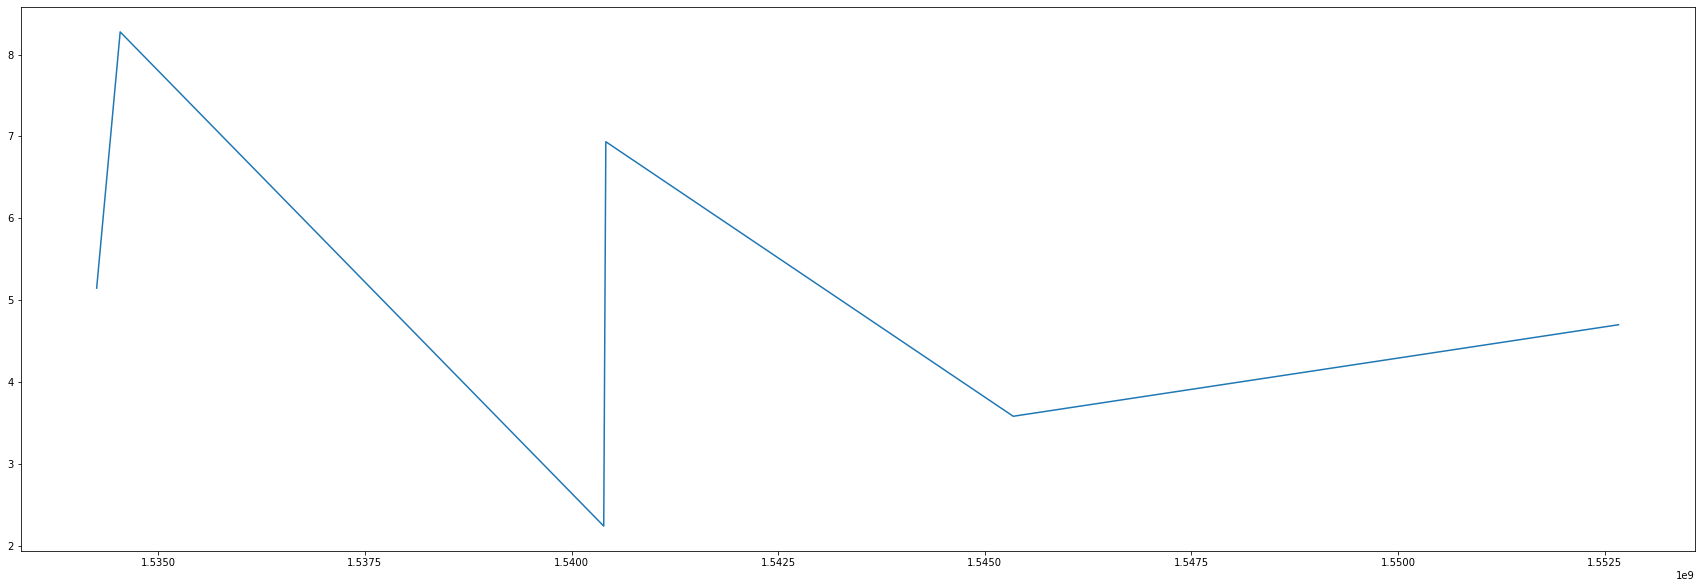

In [72]:
LOWERS_ID = '5842041f4e65fad6a770888a'
lowers = df.loc[df['SpotID'] == LOWERS_ID].sort_values(by=['UnixTime'])
plt.figure(figsize=(30,10))
plt.plot(lowers['UnixTime'], lowers['wind_speed'])

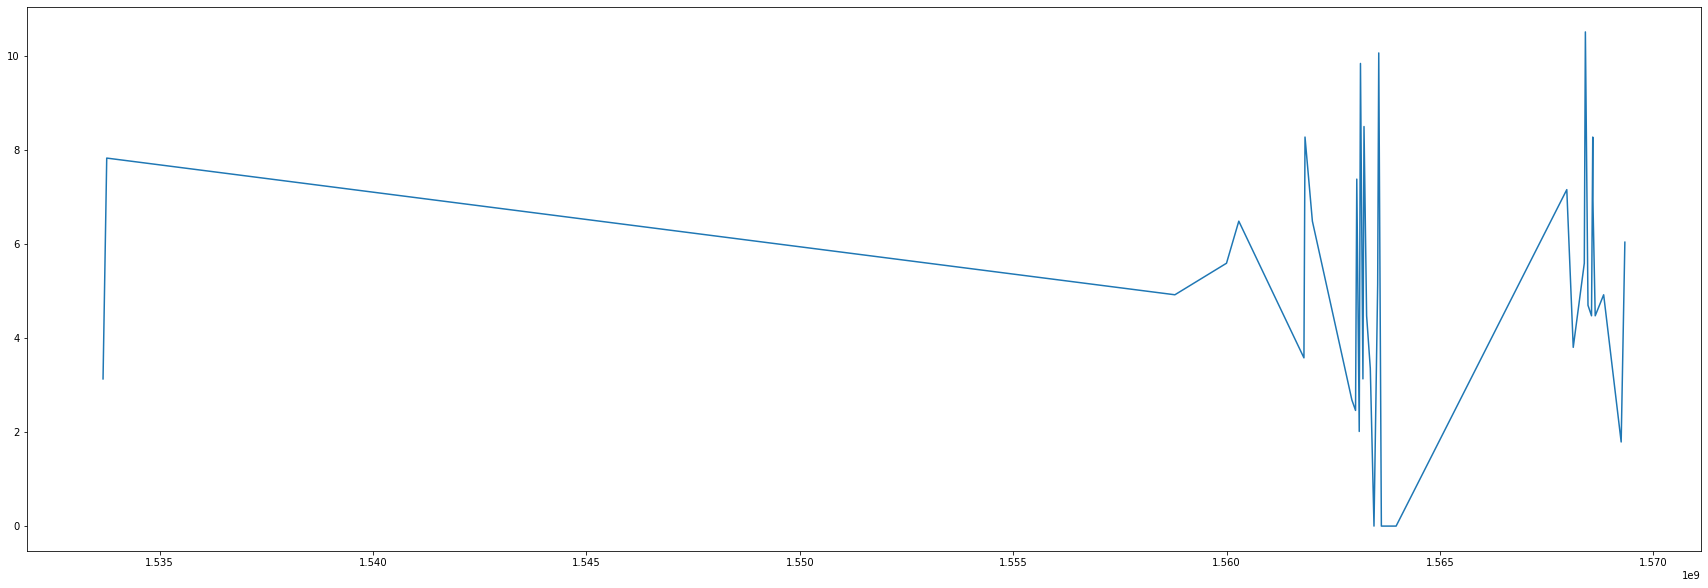

In [73]:
DOHENY_ID = '5842041f4e65fad6a77088d7'
doheny = df.loc[df['SpotID'] == DOHENY_ID].sort_values(by=['UnixTime'])
plt.figure(figsize=(30,10))
plt.plot(doheny['UnixTime'], doheny['wind_speed'])